# Imports

In [61]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from keras.preprocessing.sequence import pad_sequences
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Data Loading and Preprocessing

In [62]:
df1 = pd.read_csv("/kaggle/input/protein-data-set/pdb_data_no_dups.csv")
df2 = pd.read_csv("/kaggle/input/protein-data-set/pdb_data_seq.csv")
df2.drop(columns=['residueCount', 'macromoleculeType'], inplace=True)
df = df1.merge(df2, how='inner', on='structureId')

In [63]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,A,CCGGCGCCGG
1,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,B,CCGGCGCCGG
2,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,A,CGCGAATTCGCG
3,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,B,CGCGAATTCGCG
4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [64]:
df.shape

(471149, 16)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471149 entries, 0 to 471148
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   structureId               471149 non-null  object 
 1   classification            471145 non-null  object 
 2   experimentalTechnique     471149 non-null  object 
 3   macromoleculeType         435379 non-null  object 
 4   residueCount              471149 non-null  int64  
 5   resolution                449486 non-null  float64
 6   structureMolecularWeight  471149 non-null  float64
 7   crystallizationMethod     314754 non-null  object 
 8   crystallizationTempK      317697 non-null  float64
 9   densityMatthews           389645 non-null  float64
 10  densityPercentSol         389768 non-null  float64
 11  pdbxDetails               385468 non-null  object 
 12  phValue                   340694 non-null  float64
 13  publicationYear           413513 non-null  f

In [66]:
print(df.isnull().sum())

structureId                      0
classification                   4
experimentalTechnique            0
macromoleculeType            35770
residueCount                     0
resolution                   21663
structureMolecularWeight         0
crystallizationMethod       156395
crystallizationTempK        153452
densityMatthews              81504
densityPercentSol            81381
pdbxDetails                  85681
phValue                     130455
publicationYear              57636
chainId                         10
sequence                        28
dtype: int64


In [67]:
df = df.dropna(subset=['classification', 'sequence'])

In [68]:
categorical_cols = ['macromoleculeType', 'crystallizationMethod', 'pdbxDetails', 'chainId']
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [69]:
numerical_cols = ['resolution', 'crystallizationTempK', 'densityMatthews', 'densityPercentSol', 'phValue', 'publicationYear']
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

In [70]:
df = df[df['macromoleculeType'] == 'Protein']
df = df[df['residueCount'] < 1200]

top_classes = df['classification'].value_counts().nlargest(20).index
df = df[df['classification'].isin(top_classes)]

In [71]:
df.classification.value_counts().head(30)

classification
HYDROLASE                                29398
TRANSFERASE                              23667
OXIDOREDUCTASE                           16535
IMMUNE SYSTEM                            10731
TRANSCRIPTION                             7184
LYASE                                     6057
SIGNALING PROTEIN                         5305
TRANSPORT PROTEIN                         5072
HYDROLASE/HYDROLASE INHIBITOR             4843
ISOMERASE                                 4056
PROTEIN BINDING                           3702
VIRAL PROTEIN                             3614
STRUCTURAL GENOMICS, UNKNOWN FUNCTION     3081
LIGASE                                    3022
SUGAR BINDING PROTEIN                     2867
MEMBRANE PROTEIN                          2655
DNA BINDING PROTEIN                       2487
TRANSFERASE/TRANSFERASE INHIBITOR         2445
UNKNOWN FUNCTION                          2406
METAL BINDING PROTEIN                     2284
Name: count, dtype: int64

In [72]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['classification'])

# EDA

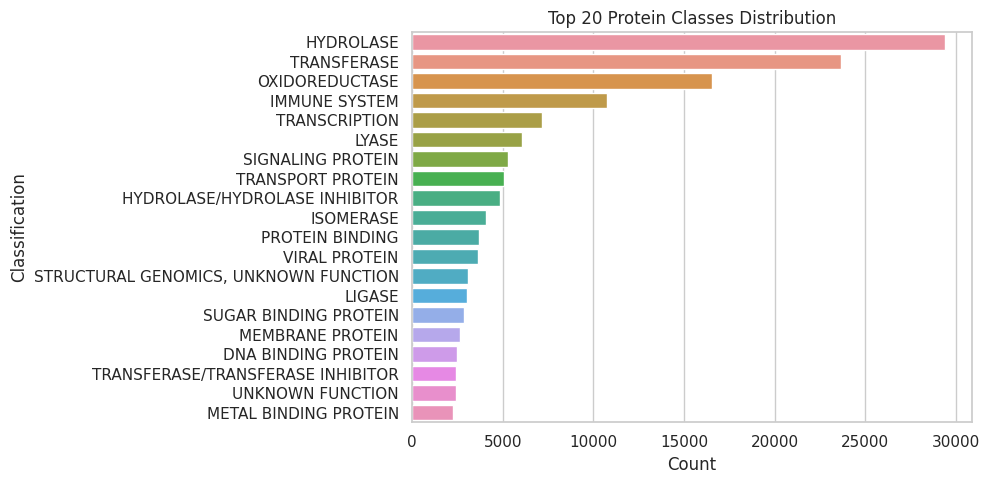

In [73]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, y='classification', order=top_classes)
plt.title("Top 20 Protein Classes Distribution")
plt.xlabel("Count")
plt.ylabel("Classification")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


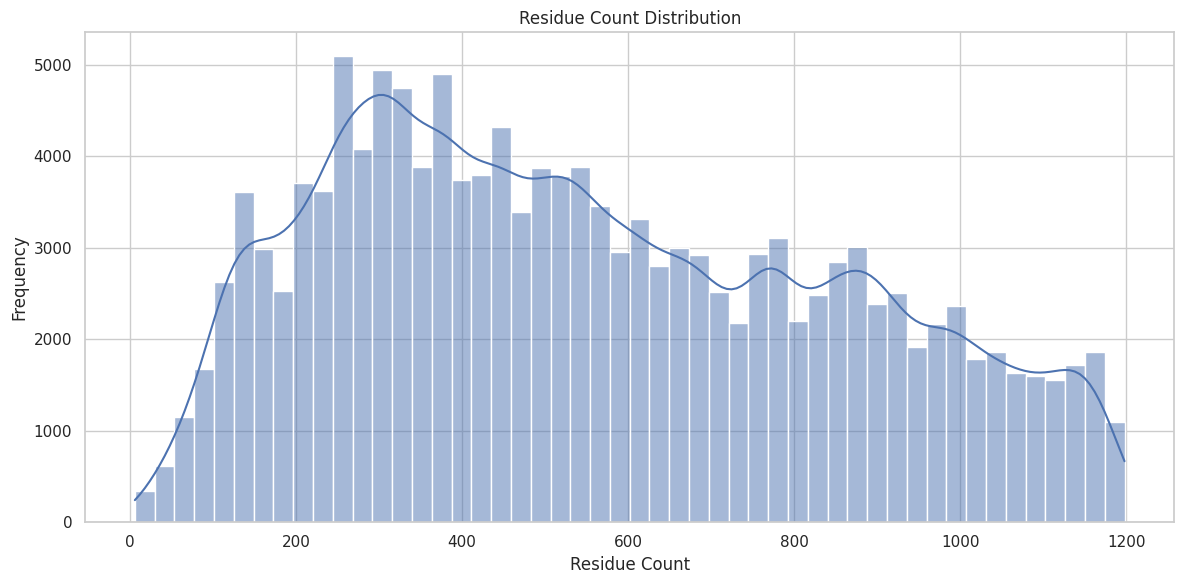

In [74]:
plt.figure(figsize=(12, 6))
sns.histplot(df['residueCount'], bins=50, kde=True)
plt.title("Residue Count Distribution")
plt.xlabel("Residue Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


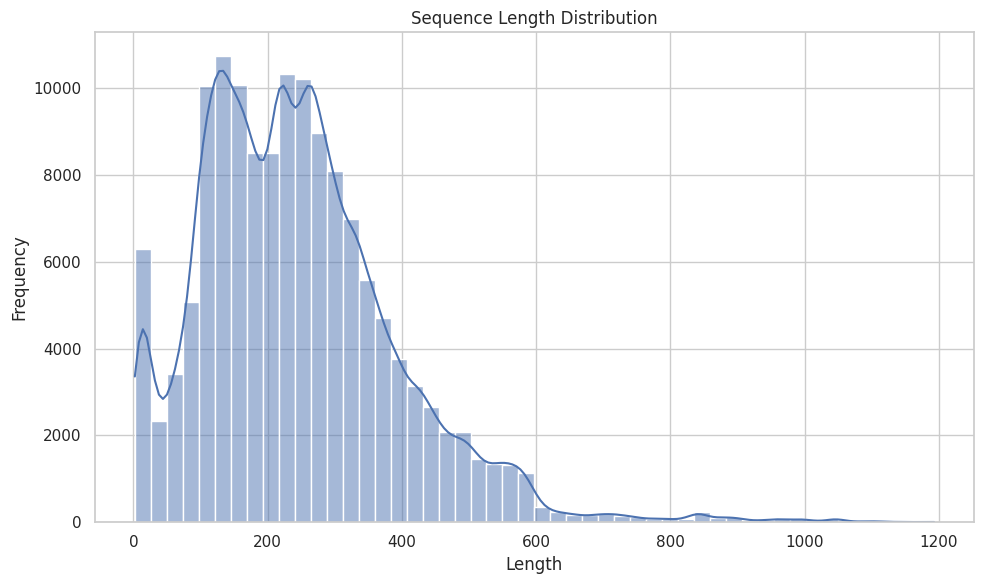

In [99]:
df['SequenceLength'] = df['sequence'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['SequenceLength'], bins=50, kde=True)
plt.title("Sequence Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

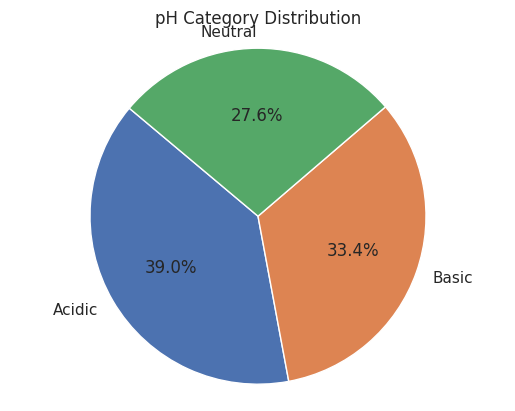

In [100]:
def ph_category(ph):
    if ph < 7: return 'Acidic'
    elif ph > 7: return 'Basic'
    else: return 'Neutral'
df['pH'] = df['phValue'].apply(ph_category)
pH_counts = df['pH'].value_counts()
plt.pie(pH_counts, labels=pH_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("pH Category Distribution")
plt.axis('equal')
plt.show()

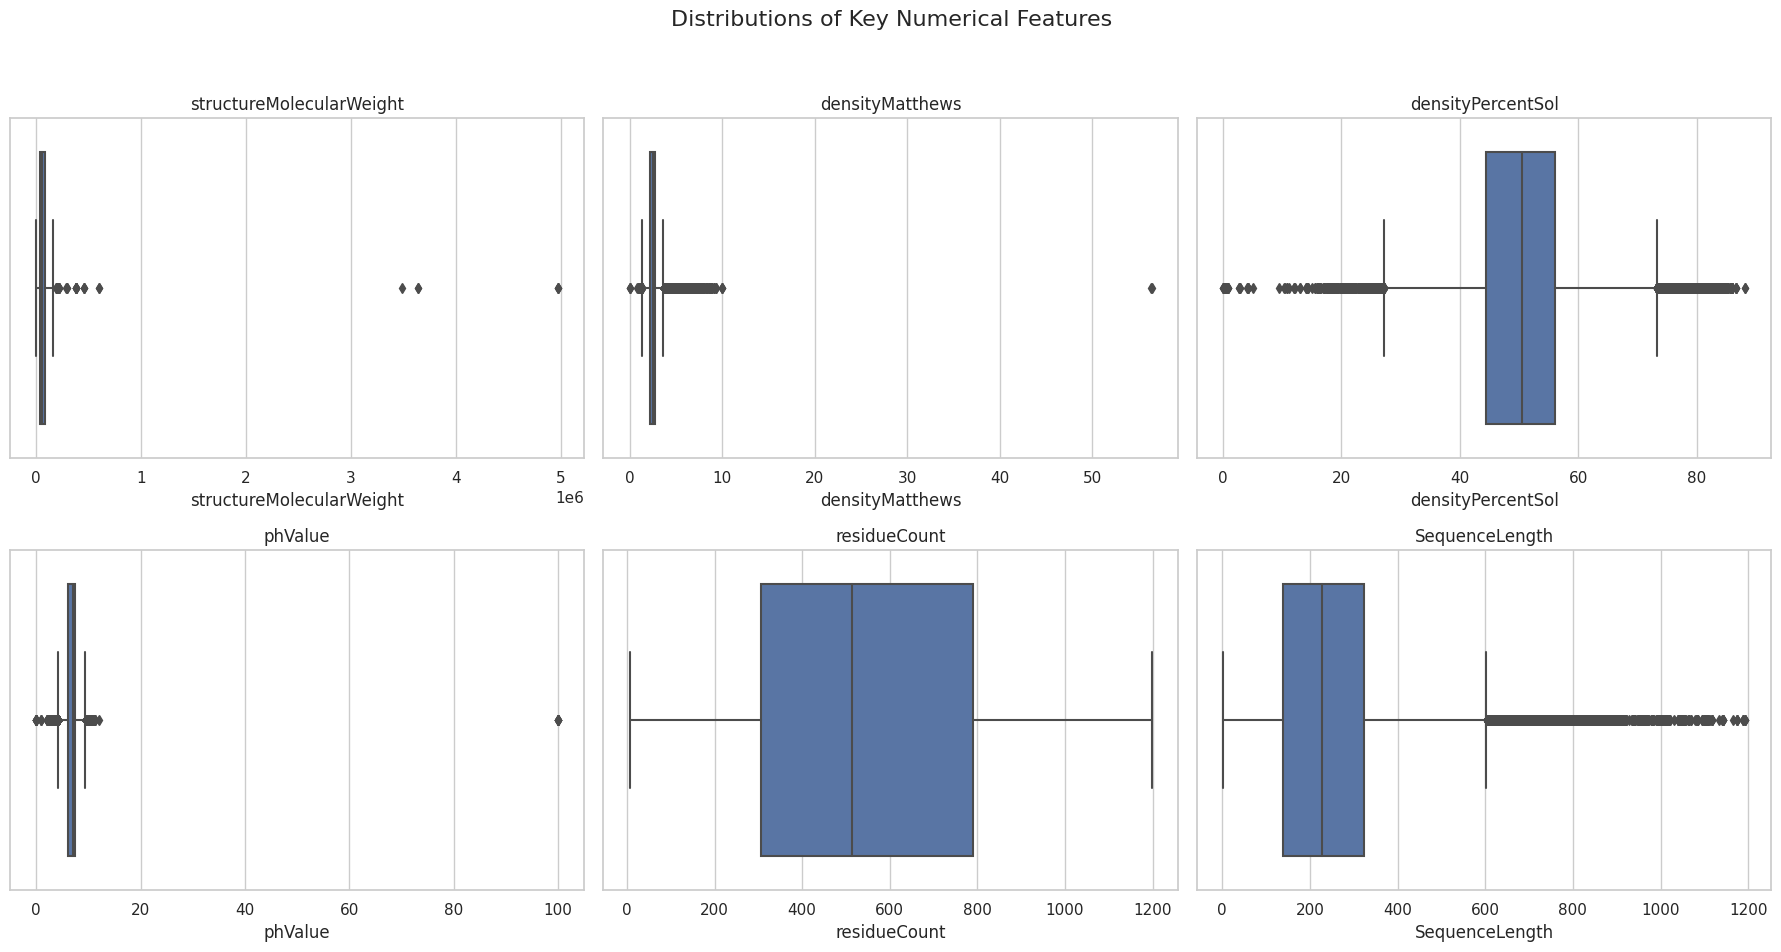

In [101]:
cols_to_plot = ['structureMolecularWeight', 'densityMatthews', 'densityPercentSol', 'phValue', 'residueCount', 'SequenceLength']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Distributions of Key Numerical Features", fontsize=16)
for ax, col in zip(axes.flatten(), cols_to_plot):
    sns.boxplot(data=df, x=col, ax=ax)
    ax.set_title(col)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Classification

In [75]:
amino_acids = list('ACDEFGHIKLMNPQRSTVWY')
aa_to_int = {aa: i+1 for i, aa in enumerate(amino_acids)} 
inv_aa_map = {v: k for k, v in aa_to_int.items()}
max_seq_len = 350

In [76]:
df['encoded_seq'] = df['sequence'].apply(lambda seq: [aa_to_int.get(aa, 0) for aa in seq if aa in aa_to_int])

In [77]:
y = df['label'].values
X = pad_sequences(df['encoded_seq'], maxlen=max_seq_len, padding='post')

In [78]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [79]:
class ProteinDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_loader = DataLoader(ProteinDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(ProteinDataset(X_val, y_val), batch_size=64)
test_loader = DataLoader(ProteinDataset(X_test, y_test), batch_size=64)

In [80]:
class ProteinBiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, num_classes=20):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.bilstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.batchnorm = nn.BatchNorm1d(hidden_dim * 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.bilstm(x)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        hidden = self.batchnorm(hidden)
        x = self.dropout(hidden)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clf_model = ProteinBiLSTMClassifier(vocab_size=len(aa_to_int)+1, num_classes=len(le.classes_)).to(device)
class_weights = torch.tensor(np.bincount(y_train)).float()
class_weights = 1.0 / class_weights
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)

clf_criterion = nn.CrossEntropyLoss(weight=class_weights)
clf_optimizer = torch.optim.Adam(clf_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(clf_optimizer, mode='max', factor=0.5, patience=2, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [83]:
def train_classifier(model, loader, valloader, epochs=10):
    for epoch in range(epochs):
        model.train()
        preds, labels = [], []
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            clf_optimizer.zero_grad()
            output = model(x)
            loss = clf_criterion(output, y)
            loss.backward()
            clf_optimizer.step()
            preds.extend(output.argmax(1).cpu().numpy())
            labels.extend(y.cpu().numpy())
        acc = accuracy_score(labels, preds)

        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for x, y in valloader:
                x, y = x.to(device), y.to(device)
                output = model(x)
                val_preds.extend(output.argmax(1).cpu().numpy())
                val_labels.extend(y.cpu().numpy())
        val_acc = accuracy_score(val_labels, val_preds)
        scheduler.step(val_acc)
        print(f"Epoch {epoch+1:02} | Train Acc: {acc:.4f} | Val Acc: {val_acc:.4f}")

train_classifier(clf_model, train_loader, val_loader, epochs=50)

Epoch 01 | Train Acc: 0.5382 | Val Acc: 0.5244
Epoch 02 | Train Acc: 0.5680 | Val Acc: 0.5714
Epoch 03 | Train Acc: 0.5921 | Val Acc: 0.5829
Epoch 04 | Train Acc: 0.6126 | Val Acc: 0.6073
Epoch 05 | Train Acc: 0.6276 | Val Acc: 0.5992
Epoch 06 | Train Acc: 0.6412 | Val Acc: 0.6135
Epoch 07 | Train Acc: 0.6515 | Val Acc: 0.6154
Epoch 08 | Train Acc: 0.6639 | Val Acc: 0.6327
Epoch 09 | Train Acc: 0.6709 | Val Acc: 0.6480
Epoch 10 | Train Acc: 0.6766 | Val Acc: 0.6481
Epoch 11 | Train Acc: 0.6834 | Val Acc: 0.6477
Epoch 12 | Train Acc: 0.6929 | Val Acc: 0.6688
Epoch 13 | Train Acc: 0.6961 | Val Acc: 0.6584
Epoch 14 | Train Acc: 0.7019 | Val Acc: 0.6625
Epoch 15 | Train Acc: 0.7041 | Val Acc: 0.6578
Epoch 16 | Train Acc: 0.7462 | Val Acc: 0.7134
Epoch 17 | Train Acc: 0.7686 | Val Acc: 0.7233
Epoch 18 | Train Acc: 0.7792 | Val Acc: 0.7242
Epoch 19 | Train Acc: 0.7862 | Val Acc: 0.7243
Epoch 20 | Train Acc: 0.7908 | Val Acc: 0.7293
Epoch 21 | Train Acc: 0.7962 | Val Acc: 0.7400
Epoch 22 | Tr

In [103]:
clf_model.eval()
val_preds, val_labels = [], []
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        output = clf_model(x)
        val_preds.extend(output.argmax(1).cpu().numpy())
        val_labels.extend(y.cpu().numpy())

val_accuracy = accuracy_score(val_labels, val_preds)
print(f"\nFinal Validation Accuracy: {val_accuracy:.4f}")

print("\nValidation Classification Report:")
print(classification_report(val_labels, val_preds, target_names=le.classes_))


Final Validation Accuracy: 0.7392

Validation Classification Report:
                                       precision    recall  f1-score   support

                  DNA BINDING PROTEIN       0.62      0.78      0.69       373
                            HYDROLASE       0.90      0.63      0.74      4410
        HYDROLASE/HYDROLASE INHIBITOR       0.42      0.85      0.56       727
                        IMMUNE SYSTEM       0.88      0.82      0.85      1610
                            ISOMERASE       0.78      0.88      0.83       608
                               LIGASE       0.67      0.77      0.72       453
                                LYASE       0.88      0.86      0.87       908
                     MEMBRANE PROTEIN       0.67      0.75      0.71       398
                METAL BINDING PROTEIN       0.49      0.77      0.60       343
                       OXIDOREDUCTASE       0.90      0.87      0.89      2480
                      PROTEIN BINDING       0.47      0.60  

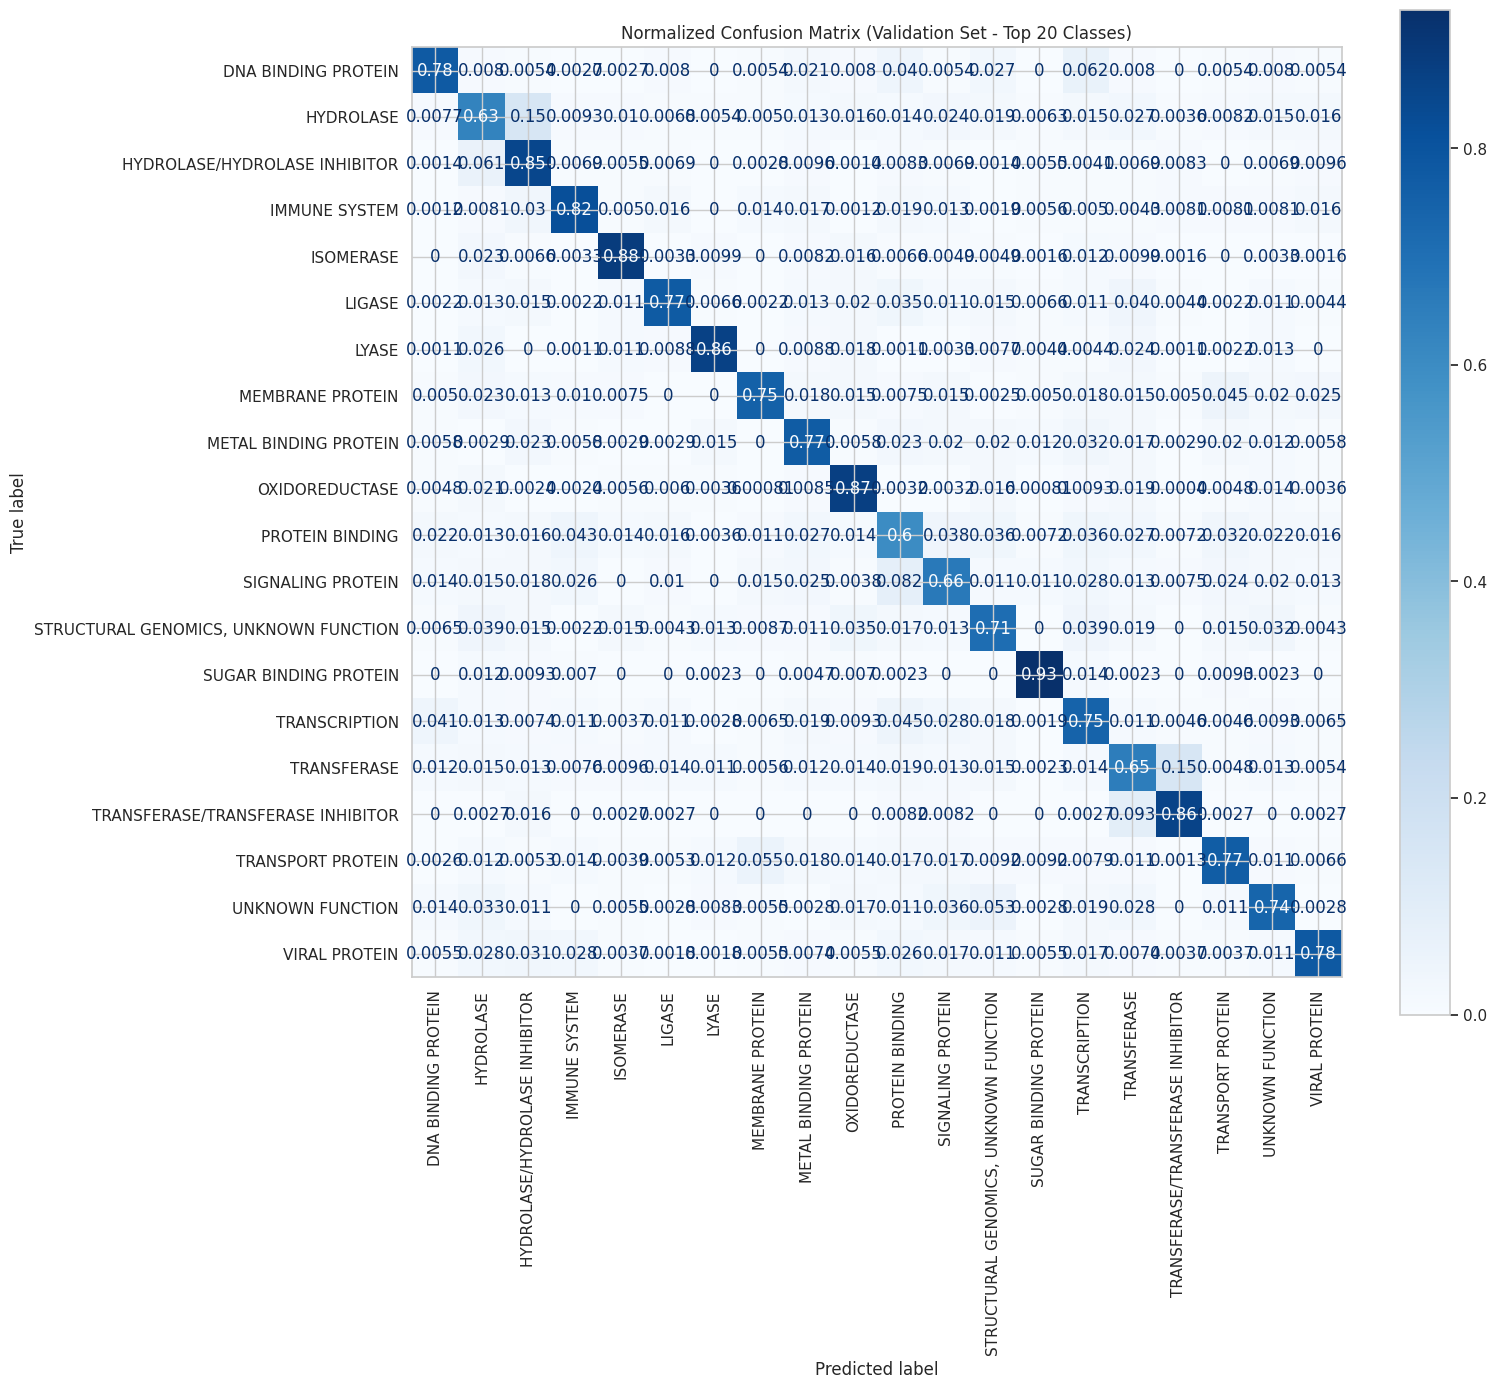

In [107]:
cm = confusion_matrix(val_labels, val_preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(16, 14))
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues')
plt.title("Normalized Confusion Matrix (Validation Set - Top 20 Classes)")
plt.tight_layout()
plt.show()

# Generation

In [86]:
amino_acids = list('ACDEFGHIKLMNPQRSTVWY')
aa_to_int = {aa: i+1 for i, aa in enumerate(amino_acids)} 
inv_aa_map = {v: k for k, v in aa_to_int.items()}
max_seq_len = 350

# Encode each sequence
df['encoded_seq'] = df['sequence'].apply(lambda seq: [aa_to_int.get(aa, 0) for aa in seq if aa in aa_to_int])

In [87]:
df_sampled = df[df['encoded_seq'].apply(lambda x: len(x) > 10)].head(20000)
input_seqs, target_tokens = [], []
max_pairs_per_seq = 30
gen_max_seq_len = 50

for seq in df_sampled['encoded_seq']:
    n = len(seq)
    if n < 2:
        continue
    indices = sorted(random.sample(range(1, n), min(n-1, max_pairs_per_seq)))
    for i in indices:
        input_seqs.append(seq[:i])
        target_tokens.append(seq[i])

X_gen = pad_sequences(input_seqs, maxlen=gen_max_seq_len, padding='pre')
y_gen = np.array(target_tokens)

In [88]:
class GeneratorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

gen_dataset = GeneratorDataset(X_gen, y_gen)
gen_loader = DataLoader(gen_dataset, batch_size=128, shuffle=True)

In [89]:
class ProteinGenerator(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.lstm(x)
        out = self.fc(output[:, -1, :])
        return out

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen_model = ProteinGenerator(vocab_size=len(aa_to_int)+1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gen_model.parameters(), lr=0.001)

In [91]:
def train_generator(model, loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1:02} | Generator Loss: {total_loss/len(loader):.4f}")

train_generator(gen_model, gen_loader, epochs=10)

Epoch 01 | Generator Loss: 2.8602
Epoch 02 | Generator Loss: 2.7601
Epoch 03 | Generator Loss: 2.6692
Epoch 04 | Generator Loss: 2.6134
Epoch 05 | Generator Loss: 2.5763
Epoch 06 | Generator Loss: 2.5478
Epoch 07 | Generator Loss: 2.5256
Epoch 08 | Generator Loss: 2.5078
Epoch 09 | Generator Loss: 2.4932
Epoch 10 | Generator Loss: 2.4824


In [92]:
def generate_sequence(model, start_seq="", max_len=100):
    model.eval()
    if not start_seq:
        start_seq = random.choice(list(aa_to_int.keys()))
    
    generated = [aa_to_int.get(aa, 0) for aa in start_seq if aa in aa_to_int]

    for _ in range(max_len - len(generated)):
        input_seq = torch.tensor([generated[-gen_max_seq_len:]], dtype=torch.long).to(device)
        with torch.no_grad():
            logits = model(input_seq)
            probs = F.softmax(logits, dim=1).squeeze().cpu().numpy()
            next_token = np.random.choice(len(probs), p=probs)
        if next_token == 0:
            break
        generated.append(next_token)

    return ''.join([inv_aa_map.get(i, '?') for i in generated if i != 0])


In [93]:
print("Generated Protein Sequences:\n")
for i in range(5):
    seq = generate_sequence(gen_model, start_seq="", max_len=100)
    print(f"Sequence {i+1}: {seq}")

Generated Protein Sequences:

Sequence 1: WGANMCAKGFRTDALTLFTADSRDAVTGTAVDRNSAADKALLVIGMKQYRGDFSAEEGCLYSALVGAMKLGSGSVDRNAQPGQDELAEVEGIRASKIIWP
Sequence 2: PIITLANESRAAERIRGYDVYNIGLTSSLCFGLGGVRTGALATMLQLGQPAMAVLHQGQTWVIEKSKEAAMAYTTQCSEQLHIKKVMPRDQGTLTIVTHK
Sequence 3: LHWFPYQQESPWKPNWNKELAEKLEKQYIMRHDHMADSVLRQGDVLTLNKVAFRCSLMGQDAEAALSKAAIRDSLIAFGLHLGRGKCLSIRAAALFAQVP
Sequence 4: GEARIEWFQMDGKTSMEEFWRASRNQCDVSIVGGIPFPDVENGGHKISSGIHQPSDKNALNINVKKPEAFIVEQRIYIGRDVREERRKQREKRIKMLGAI
Sequence 5: DWVWSFQNNKDYGYGDIKYNRDADQAKDLISLVFEMNQLKPRSWANADRTAGQKGRGDRYTFTIGRSATTFVTGSGVAGSPPLVIYPASAWYSATTYTFV


# Reclassifying Generated Sequences

In [94]:
def classify_sequence(sequence, model, max_len=350):
    encoded = [aa_to_int.get(aa, 0) for aa in sequence]
    padded = torch.tensor([encoded[:max_len] + [0]*(max(0, max_len - len(encoded)))], dtype=torch.long).to(device)
    model.eval()
    with torch.no_grad():
        output = model(padded)
        pred = output.argmax(1).cpu().item()
    return le.inverse_transform([pred])[0]

In [95]:
print("\nReclassified Generated Sequences:\n")
for i in range(5):
    seq = generate_sequence(gen_model, start_seq="", max_len=100)
    pred_class = classify_sequence(seq, clf_model)
    print(f"Sequence {i+1}: {seq}")
    print(f"Predicted Class: {pred_class}\n")


Reclassified Generated Sequences:

Sequence 1: VNGEETEPPTGGKLYRGALGVETDANATYYAAEDMTLVRAHAGGSGGLSGKPGVPDLAPRSRLAAVRKSASSAVFVWASTAADTLGIDVASRVAHYVPTA
Predicted Class: HYDROLASE/HYDROLASE INHIBITOR

Sequence 2: ENGCPAHRFHAGGGSCGGYGSGKCGLPDRSCTGSPKSPCCSCKRTSATCECQDKTGPCYESPKSDINRENKLTRICSIPKNSYSNKRNCNKKKKFYVDFH
Predicted Class: SUGAR BINDING PROTEIN

Sequence 3: MMQYPGLPWGKQLAEVVVEKTYEQEMAKELHEKLNKFKEKHIAEHVEKSQEAAMAQALLGEKETKALLDAELGIDKARTRRGAIEIIFLTVAFSQISPDA
Predicted Class: PROTEIN BINDING

Sequence 4: AFWNMGKGNTWDADAKTFLLTRASGEPVTTCTVSGGSGVHFCGAALVSSGTVTLGNDVCKSGVTERYTLQPGKVTVKPESTLSAAVACCAGLSSQSLIGW
Predicted Class: IMMUNE SYSTEM

Sequence 5: HGLNAKYDGKHFINTIIKNNHKWVDSRGNAEYIGPYAARGIRFIEIEFHRNNIEKIKAPRNIKYWDRLFDGSADFYQAEYMTGFTGGHFCALYEFAQSKK
Predicted Class: MEMBRANE PROTEIN



# Saving for Flask

In [98]:
torch.save(clf_model.state_dict(), "protein_classifier.pt")

import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)